In [1]:
# Pagrindinės bibliotekos
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # Vizualizacijai, atkreipkite dėmesį, kad naudojame "matplotlib" pagrindu
import warnings
import requests
from datetime import datetime
from bs4 import BeautifulSoup
import time
import sqlite3

# Duomenų modeliavimas ir analizė
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Darbas su interneto naršyklėmis per Selenium
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

# Įspėjimų ignoravimas
warnings.filterwarnings('ignore')

# Specializuoti moduliai
from numpy.polynomial import Polynomial

import json
from sklearn.preprocessing import StandardScaler
from datetime import timedelta

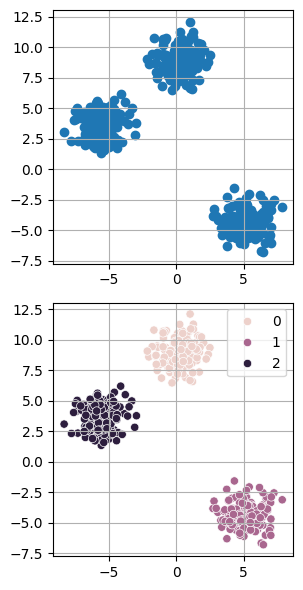

In [2]:
# Klasterizavimas su scikit-learn 
# k-Means 

from sklearn.datasets import make_blobs
X,y = make_blobs(n_samples = 500,n_features = 2,centers = 3,random_state = 23)
fig, (axis, ax) = plt.subplots(2, gridspec_kw={'height_ratios':[1,1]}, figsize=[3,6])
axis.grid(True)
axis.scatter(X[:,0], X[:,1])
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, ax=ax)
ax.grid(True)
fig.tight_layout()
plt.show()


In [3]:
from sklearn.cluster import KMeans

In [4]:
kmeans = KMeans(n_clusters=3)
predicted_labels = kmeans.fit_predict(X)

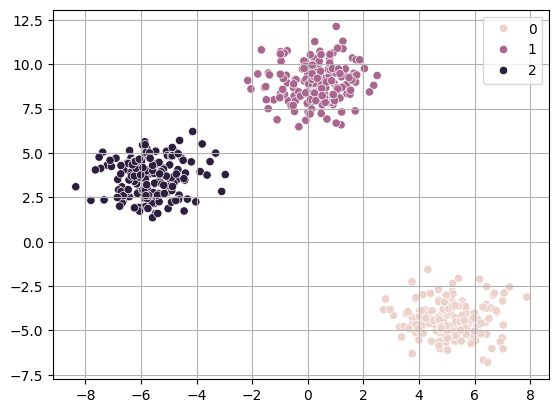

In [5]:
ax = sns.scatterplot(x=X[:,0], y=X[:,1], hue=predicted_labels)
ax.grid(True)
plt.show()

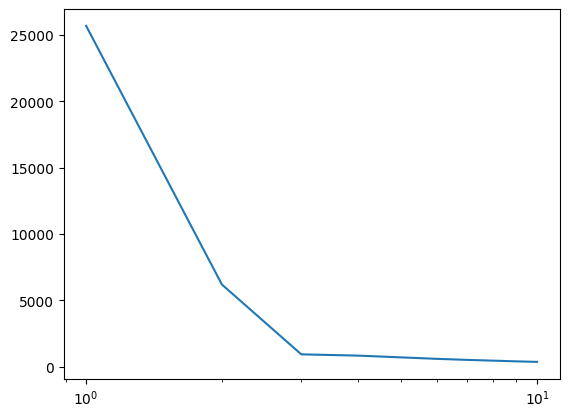

In [6]:
# Teisingo klasterio skaiciaus nustatymas
sse = []
for k in range(1, 11):
    km = KMeans(n_clusters=k)
    km.fit(X)
    sse.append(km.inertia_)

ax = sns.lineplot(x=range(1, 11), y=sse)
ax.set(xscale="log")
plt.show()


In [7]:
#  Aruodas skelbimai
# Į kiek klasterių galima suskirstyti Vilniuje esančius sklebimus?
# X - features yra skelbimo koordinatės
# Ar galite suskaičiuoti kiekviename klasteryje esančią vidutinę būsto kainą?
# ?Atvaizduokite duoenis su mapbox()

In [25]:
conn = sqlite3.connect('aruodas3.db')
df = pd.read_sql_query("SELECT * FROM aruododuomenys", conn)
df = df[df['miestas'] == 'Vilnius']
df = df[['ilguma', 'platuma']]
df = df.dropna(subset=['ilguma', 'platuma'])
df

,ilguma,platuma
0,54.701257,25.272667
1,54.705467,25.286944
2,54.717923,25.238122
3,54.691637,25.284638
4,54.707286,25.286241
...,...,...
3084,54.682515,25.220766
3085,54.710757,25.287010
3086,54.700492,25.307491
3087,54.714199,25.313860


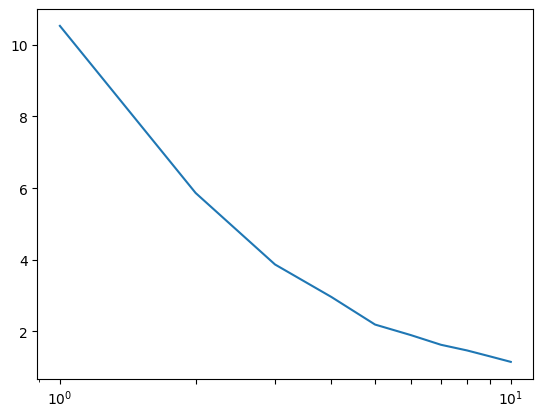

In [26]:
sse = []
for k in range(1, 11):
    km = KMeans(n_clusters=k)
    km.fit(df)
    sse.append(km.inertia_)

ax = sns.lineplot(x=range(1, 11), y=sse)
ax.set(xscale="log")
plt.xticks(range(1, 11))
plt.show()



In [34]:
results_df = pd.DataFrame({'Cluster Count': range(1, 11), 'SSE': sse})
results_df
results_df['SSE %'] = results_df['SSE'].pct_change() * 100
results_df

,Cluster Count,SSE,SSE %
0,1,10.529786,NaN
1,2,5.864665,-44.304041
2,3,3.868061,-34.044648
3,4,2.961184,-23.445246
4,5,2.190687,-26.019913
5,6,1.897239,-13.395262
6,7,1.626318,-14.279717
7,8,1.467835,-9.744920
8,9,1.300970,-11.368102
9,10,1.148941,-11.685788


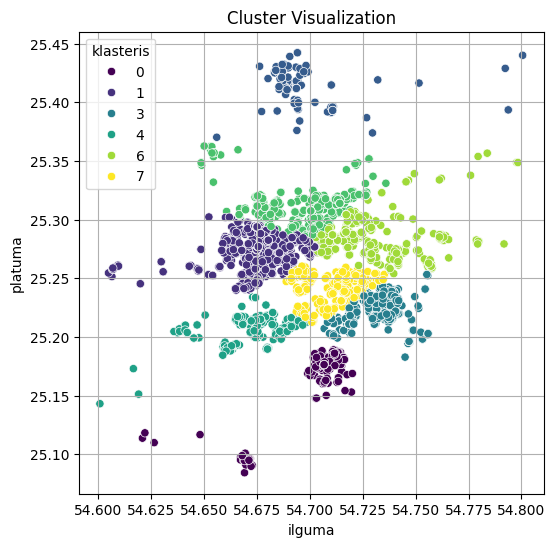

In [35]:
kmeans = KMeans(n_clusters=8, random_state=23)
df['klasteris'] = kmeans.fit_predict(df[['ilguma', 'platuma']])

# Plotting the clusters
plt.figure(figsize=[6, 6])
sns.scatterplot(x='ilguma', y='platuma', hue='klasteris', data=df, palette='viridis')
plt.title('Cluster Visualization')
plt.grid(True)
plt.show()

In [36]:
df

,ilguma,platuma,klasteris
0,54.701257,25.272667,1
1,54.705467,25.286944,6
2,54.717923,25.238122,7
3,54.691637,25.284638,1
4,54.707286,25.286241,6
...,...,...,...
3084,54.682515,25.220766,4
3085,54.710757,25.287010,6
3086,54.700492,25.307491,5
3087,54.714199,25.313860,5


In [37]:
import plotly.express as px

fig = px.scatter_mapbox(df, lat='ilguma', lon='platuma', color='klasteris', mapbox_style="open-street-map")
fig.show()

In [40]:
# GridSearchCV 

from sklearn.model_selection import GridSearchCV # su gridsearchcv tuninsime parametrus
# Define the parameter grid
param_grid = {
'n_clusters': range(2, 6 + 1),
'init': ['k-means++', 'random'],
'n_init': [5, 10, 15],
'max_iter': [100, 200, 300, 400, 500],
'tol': [0.0001, 0.001, 0.01],
'algorithm': ['auto', 'full', 'elkan'],
'random_state': [0, 42, 100]
}

# Create the KMeans object
kmeans = KMeans(random_state=42)

# Perform grid search
grid_search = GridSearchCV(kmeans, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X) # fitinam X, kurį susigeneravom darbo pradžioje

# Print the best hyperparameters
print("Best hyperparameters: ", grid_search.best_params_)
print('Optimal number of clusters based on parameter grid: ' + str(grid_search.best_params_['n_clusters']))


Best hyperparameters:  {'algorithm': 'elkan', 'init': 'k-means++', 'max_iter': 100, 'n_clusters': 6, 'n_init': 15, 'random_state': 42, 'tol': 0.001}
Optimal number of clusters based on parameter grid: 6


In [42]:
df

,ilguma,platuma,klasteris
0,54.701257,25.272667,1
1,54.705467,25.286944,6
2,54.717923,25.238122,7
3,54.691637,25.284638,1
4,54.707286,25.286241,6
...,...,...,...
3084,54.682515,25.220766,4
3085,54.710757,25.287010,6
3086,54.700492,25.307491,5
3087,54.714199,25.313860,5


In [41]:
conn = sqlite3.connect('aruodas3.db')
df2 = pd.read_sql_query("SELECT * FROM aruododuomenys", conn)
df2 = df2[df2['miestas'] == 'Vilnius']
df2

,plotas,kambariuskaicius,aukstas,aukstuskaicius,metai,pastatotipas,sildymas,irengimas,energetineklase,ilguma,platuma,miestas,kaina,rajonas
0,"34,93 m²",2,5,5,2023,Mūrinis,Centrinis kolektorinis,Įrengtas,None,54.701257,25.272667,Vilnius,173500,Šnipiškės
1,"66,64 m²",2,3,5,2003,Mūrinis,Centrinis,Įrengtas,A,54.705467,25.286944,Vilnius,205000,Žirmūnai
2,"66,89 m²",3,2,9,1980,Blokinis,Centrinis,Įrengtas,None,54.717923,25.238122,Vilnius,172000,Šeškinė
3,98 m²,3,2,5,2008,Mūrinis,Centrinis,Įrengtas,A+,54.691637,25.284638,Vilnius,615000,Šnipiškės
4,"46,23 m²",3,3,5,1969,Blokinis,Centrinis,Įrengtas,D,54.707286,25.286241,Vilnius,147500,Šnipiškės
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3084,78 m²,4,4,5,1970,Blokinis,Centrinis,Įrengtas,None,54.682515,25.220766,Vilnius,150000,Lazdynai
3085,"54,19 m²",3,7,9,1990,Mūrinis,Centrinis,Dalinė apdaila,None,54.710757,25.287010,Vilnius,137000,Šnipiškės
3086,"110,81 m²",4,1,2,1940,Mūrinis,Kita,Kita,None,54.700492,25.307491,Vilnius,277025,Antakalnis
3087,"17,21 m²",1,1,2,1940,Rąstinis,Kita,Kita,None,54.714199,25.313860,Vilnius,36140,Antakalnis


In [46]:
bendras_df = pd.merge(df2, df[['platuma', 'ilguma', 'klasteris']], on=['platuma', 'ilguma'], how='left')
bendras_df = bendras_df[bendras_df['kambariuskaicius'] == 2]
bendras_df


,plotas,kambariuskaicius,aukstas,aukstuskaicius,metai,pastatotipas,sildymas,irengimas,energetineklase,ilguma,platuma,miestas,kaina,rajonas,klasteris
0,"34,93 m²",2,5,5,2023,Mūrinis,Centrinis kolektorinis,Įrengtas,None,54.701257,25.272667,Vilnius,173500,Šnipiškės,1.0
1,"34,93 m²",2,5,5,2023,Mūrinis,Centrinis kolektorinis,Įrengtas,None,54.701257,25.272667,Vilnius,173500,Šnipiškės,1.0
2,"34,93 m²",2,5,5,2023,Mūrinis,Centrinis kolektorinis,Įrengtas,None,54.701257,25.272667,Vilnius,173500,Šnipiškės,1.0
3,"66,64 m²",2,3,5,2003,Mūrinis,Centrinis,Įrengtas,A,54.705467,25.286944,Vilnius,205000,Žirmūnai,6.0
4,"66,64 m²",2,3,5,2003,Mūrinis,Centrinis,Įrengtas,A,54.705467,25.286944,Vilnius,205000,Žirmūnai,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7421,"46,9 m²",2,2,4,1956,Mūrinis,Centrinis,Įrengtas,None,54.680436,25.282496,Vilnius,225000,Senamiestis,1.0
7445,54 m²,2,2,4,None,Mūrinis,Centrinis,Įrengtas,None,54.676779,25.288049,Vilnius,300000,Senamiestis,1.0
7446,54 m²,2,2,4,None,Mūrinis,Centrinis,Įrengtas,None,54.676779,25.288049,Vilnius,300000,Senamiestis,1.0
7447,54 m²,2,2,4,None,Mūrinis,Centrinis,Įrengtas,None,54.676779,25.288049,Vilnius,300000,Senamiestis,1.0


In [ ]:
kmeans = KMeans(n_clusters=8, random_state=23)
df['klasteris'] = kmeans.fit_predict(df[['ilguma', 'platuma']])

# Plotting the clusters
plt.figure(figsize=[6, 6])
sns.scatterplot(x='ilguma', y='platuma', hue='klasteris', data=df, palette='viridis')
plt.title('Cluster Visualization')
plt.grid(True)
plt.show()

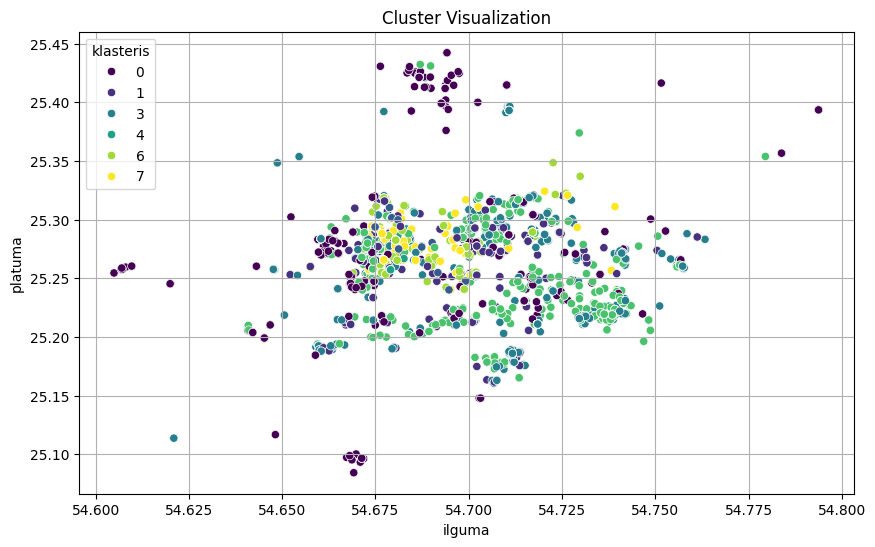

In [47]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'kaina' is a column in your DataFrame, and you have appropriate data in it
# Check for any missing values in the columns and handle them if necessary
bendras_df.dropna(subset=['platuma', 'ilguma', 'kaina'], inplace=True)

# Initializing KMeans
kmeans = KMeans(n_clusters=8, random_state=23)

# Fitting the model on the specified columns
bendras_df['klasteris'] = kmeans.fit_predict(bendras_df[['platuma', 'ilguma', 'kaina']])

# Plotting the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='ilguma', y='platuma', hue='klasteris', data=bendras_df, palette='viridis')
plt.title('Cluster Visualization')
plt.grid(True)
plt.show()


In [48]:
# Using Plotly to create a scatter mapbox
fig = px.scatter_mapbox(bendras_df, lat='ilguma', lon='platuma', color='klasteris', 
                        color_continuous_scale=px.colors.cyclical.IceFire, 
                        mapbox_style="open-street-map")

# Show the figure
fig.show()

In [ ]:
# aruodo - pridėti kainą už 1 kv. m, pritaikyti ir elbow metodą, ir gridsearch'ą
# du grafikai - su klasterių kiekiu iš elbow metodo
# grafikas - su klasterių kiekiu, nurodant parametrus iš gridsearchcv